# The Battle of Neighborhoods : Finding a Familiar Neighborhood

In [56]:
import pandas as pd
import numpy as np
import requests
import json
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt

In [3]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                       

#### Extracting n preparing Canada dataset

In [4]:
txt=requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup=BeautifulSoup(txt, 'lxml')
table=soup.find('table')
df_ca=pd.DataFrame(columns=['PostalCode','Borough','Neighborhood'])
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_ca.loc[len(df_ca)]=row
df_ca.drop(0, inplace=True)
df_ca.drop(df_ca[df_ca['Borough']=='Not assigned'].index, inplace=True)
df_ca=df_ca.groupby(['PostalCode','Borough'], sort=False)['Neighborhood'].apply(lambda x: "%s" % ','.join(x))
df_ca=df_ca.reset_index()
df_ca.loc[df_ca['Neighborhood'] =='Not assigned', 'Neighborhood'] = df_ca['Borough']
df_geo=pd.read_csv('https://cocl.us/Geospatial_data')
df_geo.columns=['PostalCode', 'Latitude', 'Longitude']
df_ca=df_ca.merge(df_geo, on='PostalCode')
df_ca.drop("PostalCode", inplace=True, axis=1)
print(df_ca['Borough'].value_counts())
print(df_ca.shape)
df_ca.head()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East York            5
East Toronto         5
York                 5
Mississauga          1
Name: Borough, dtype: int64
(103, 4)


Borough                                 Neighborhood   Latitude  \
0        North York                                    Parkwoods  43.753259   
1        North York                             Victoria Village  43.725882   
2  Downtown Toronto                    Regent Park, Harbourfront  43.654260   
3        North York             Lawrence Manor, Lawrence Heights  43.718518   
4  Downtown Toronto  Queen's Park, Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

#### Extracting n preparing New York dataset

In [5]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
df_ny=neighborhoods
df_ny.drop(df_ny[df_ny['Borough']=='Queens'].index, inplace=True)
df_ny.drop(df_ny[df_ny['Borough']=='Brooklyn'].index, inplace=True)
df_ny.reset_index(inplace=True)
df_ny.drop('index', axis=1, inplace=True)
print(df_ny['Borough'].value_counts())
print(df_ny.shape)
df_ny.head()

Staten Island    63
Bronx            52
Manhattan        40
Name: Borough, dtype: int64
(155, 4)


Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

#### Extracting n preparing Bangalore dataset

In [6]:
txt=requests.get('https://www.indiatvnews.com/pincode/karnataka/bangalore/').text
soup=BeautifulSoup(txt, 'lxml')
table=soup.find('table')
df_blr=pd.DataFrame(columns=['Neighborhood','Borough','district','state','pincode'])
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_blr.loc[len(df_blr)]=row
df_blr.drop(0, inplace=True)
df_blr.drop(df_blr[df_blr['Borough']=='NA'].index, inplace=True)
df_blr=df_blr.groupby(['pincode','Borough'], sort=False)['Neighborhood'].apply(lambda x: "%s" % ','.join(x))
df_blr=df_blr.reset_index()
df_blr.loc[df_blr['Neighborhood'] =='NA', 'Neighborhood'] = df_blr['Borough']
df=pd.DataFrame(columns=['pincode','Latitude', 'Longitude'])
for pincode in df_blr['pincode']:
    address = str(pincode)+', Bangalore, Karnataka, India'
    geolocator = Nominatim(user_agent="kk_explorer")
    location = geolocator.geocode(address)
    if hasattr(location,'latitude') and hasattr(location,'longitude'):
        row=[pincode,location.latitude, location.longitude]
    else:
        row=[pincode,'NA', 'NA']
    df.loc[len(df)]=row
df_blr=df_blr.merge(df, on='pincode')
df_blr.drop_duplicates(inplace=True)
df_blr.drop(df_blr[df_blr['Latitude']=='NA'].index, inplace=True)
df_blr.drop('pincode', axis=1, inplace=True)
df_blr.reset_index(inplace=True)
df_blr.drop('index', axis=1, inplace=True)
print(df_blr['Borough'].value_counts())
print(df_blr.shape)
df_blr.head()

Bangalore North    62
Bangalore South    39
Bangalore           9
Anekal              5
Bg North            2
Bangaloresouth      1
Nla & Bgsouth       1
Bgsouth             1
Banglore            1
Bg South            1
Magadi              1
Bangalore north     1
Devanahalli         1
Banglorenorth       1
Bgnorth             1
Name: Borough, dtype: int64
(127, 4)


Borough                                       Neighborhood  \
0  Bangalore North         A F Station Yelahanka,BSF Campus Yelahanka   
1  Bangalore South                                              Agram   
2  Bangalore North                                 Air Force Hospital   
3  Bangalore North  Amruthahalli,Byatarayanapura,Kodigehalli,Sahak...   
4  Bangalore North    Anandnagar Bangalore,H.A. Farm,Hebbal Kempapura   

  Latitude Longitude  
0  12.8987   77.6393  
1  12.9686   77.6303  
2  12.9686   77.6303  
3  13.0603   77.5842  
4  13.0237   77.5844

#### Extracting n preparing Hyderabad dataset

In [7]:
txt=requests.get('https://www.indiatvnews.com/pincode/telangana/hyderabad').text
soup=BeautifulSoup(txt, 'lxml')
table=soup.find('table')
df_hyd=pd.DataFrame(columns=['Neighborhood','Borough','district','state','pincode'])
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_hyd.loc[len(df_hyd)]=row
df_hyd.drop(0, inplace=True)
df_hyd.drop(df_hyd[df_hyd['Borough']=='NA'].index, inplace=True)
df_hyd=df_hyd.groupby(['pincode','Borough'], sort=False)['Neighborhood'].apply(lambda x: "%s" % ','.join(x))
df_hyd=df_hyd.reset_index()
df_hyd.loc[df_hyd['Neighborhood'] =='NA', 'Neighborhood'] = df_hyd['Borough']
df=pd.DataFrame(columns=['pincode','Latitude', 'Longitude'])
for pincode in df_hyd['pincode']:
    address = str(pincode)+', Hyderabad, Telangana, India'
    geolocator = Nominatim(user_agent="ny_explorer", timeout=10)
    location = geolocator.geocode(address)
    if hasattr(location,'latitude') and hasattr(location,'longitude'):
        row=[pincode,location.latitude, location.longitude]
    else:
        row=[pincode,'NA', 'NA']
    df.loc[len(df)]=row
df_hyd=df_hyd.merge(df, on='pincode')
df_hyd.drop_duplicates(inplace=True)
df_hyd.drop(df_hyd[df_hyd['Latitude']=='NA'].index, inplace=True)
df_hyd.drop('pincode', axis=1, inplace=True)
df_hyd.reset_index(inplace=True)
df_hyd.drop('index', axis=1, inplace=True)
print(df_hyd['Borough'].value_counts())
print(df_hyd.shape)
df_hyd.head()

Tirumalagiri           21
Secunderabad           12
Hyderabad              11
Hyd                     8
Khairatabad             7
Nampally                6
Rajendranagar           6
Charminar               6
Himayathnagar           4
Rangareddy              4
Shaikpet                3
Golconda                3
Saidabad                3
Saroornagar             3
Bandlaguda              3
Asifnagar               3
Hayathnagar             2
Amberpet                2
Uppal                   2
Ameerpet                2
Balanagar               2
Musheerabad             2
Serilingampally         2
Ghatkesar               2
Rajendra Nagar          1
saroornagar             1
Seri Lingampally        1
Qutubullapur            1
Shamirpet Mandal        1
Vikarabad               1
Quthbullapur Mandal     1
Bahadurpura             1
Malkagiri Manda         1
Name: Borough, dtype: int64
(128, 4)


Borough                                       Neighborhood Latitude  \
0     Khairatabad  A.Gs Office,Anandnagar Hyderabad,Bazarghat Hyd...  17.3962   
1   Himayathnagar                                   Parishram Bhawan  17.3962   
2        Nampally                             Vidhan Sabha Hyderabad  17.3962   
3     Khairatabad                    A.Gs. Staff Quarters,Yousufguda  17.4374   
4  Rajendra Nagar                               AP Police Academy PO   17.528   

  Longitude  
0   78.4631  
1   78.4631  
2   78.4631  
3    78.428  
4    78.267

#### Extracting n preparing Mumbai dataset

In [8]:
txt=requests.get('https://www.indiatvnews.com/pincode/maharashtra/mumbai').text
soup=BeautifulSoup(txt, 'lxml')
table=soup.find('table')
df_bom=pd.DataFrame(columns=['Neighborhood','Borough','district','state','pincode'])
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_bom.loc[len(df_bom)]=row
df_bom.drop(0, inplace=True)
df_bom.drop(df_bom[df_bom['Borough']=='NA'].index, inplace=True)
df_bom=df_bom.groupby(['pincode','Borough'], sort=False)['Neighborhood'].apply(lambda x: "%s" % ','.join(x))
df_bom=df_bom.reset_index()
df_bom.loc[df_bom['Neighborhood'] =='NA', 'Neighborhood'] = df_bom['Borough']
df=pd.DataFrame(columns=['pincode','Latitude', 'Longitude'])
for pincode in df_bom['pincode']:
    address = str(pincode)+', Mumbai, Maharashtra, India'
    geolocator = Nominatim(user_agent="ny_explorer", timeout=10)
    location = geolocator.geocode(address)
    if hasattr(location,'latitude') and hasattr(location,'longitude'):
        row=[pincode,location.latitude, location.longitude]
    else:
        row=[pincode,'NA', 'NA']
    df.loc[len(df)]=row
df_bom=df_bom.merge(df, on='pincode')
df_bom.drop_duplicates(inplace=True)
df_bom.drop(df_bom[df_bom['Latitude']=='NA'].index, inplace=True)
df_bom.drop('pincode', axis=1, inplace=True)
df_bom.reset_index(inplace=True)
df_bom.drop('index', axis=1, inplace=True)
print(df_bom['Borough'].value_counts())
print(df_bom.shape)
df_bom.head()

Mumbai             54
Borivali West       3
Jogeshwari East     2
Goregaon East       2
Malad West          2
Kandivali East      1
Borivali East       1
Kandivali West      1
Borivlai East       1
Bandra              1
Kandivlai West      1
Goregaon West       1
Dahisar East        1
Malad East          1
Dahisar West        1
Jogeshwari West     1
Name: Borough, dtype: int64
(74, 4)


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Borough                                       Neighborhood   Latitude  \
0  Mumbai               Antop Hill,B P T Colony,C G S Colony  19.023074   
1  Mumbai  Chamarbaug,Haffkin Institute,Lal Baug,Parel Na...  18.996311   
2  Mumbai  Cotton Exchange,Kalachowki,L B S N E collage,R...  18.938771   
3  Mumbai                  Dadar Colony,Dadar,Naigaon Mumbai  19.010619   
4  Mumbai  Dockyard Road,Mazgaon Dock,Mazgaon Road,Mazgao...  18.968523   

   Longitude  
0  72.867622  
1  72.842493  
2  72.835335  
3  72.846936  
4  72.837844

#### Extracting n preparing Pune dataset

In [9]:
txt=requests.get('https://www.indiatvnews.com/pincode/maharashtra/pune').text
soup=BeautifulSoup(txt, 'lxml')
table=soup.find('table')
df_pnq=pd.DataFrame(columns=['Neighborhood','Borough','district','state','pincode'])
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_pnq.loc[len(df_pnq)]=row
df_pnq.drop(0, inplace=True)
df_pnq.drop(df_pnq[df_pnq['Borough']=='NA'].index, inplace=True)
df_pnq=df_pnq.groupby(['pincode','Borough'], sort=False)['Neighborhood'].apply(lambda x: "%s" % ','.join(x))
df_pnq=df_pnq.reset_index()
df_pnq.loc[df_pnq['Neighborhood'] =='NA', 'Neighborhood'] = df_pnq['Borough']
df=pd.DataFrame(columns=['pincode','Latitude', 'Longitude'])
for pincode in df_pnq['pincode']:
    address = str(pincode)+', Pune, Maharashtra, India'
    geolocator = Nominatim(user_agent="ny_explorer", timeout=10)
    location = geolocator.geocode(address)
    if hasattr(location,'latitude') and hasattr(location,'longitude'):
        row=[pincode,location.latitude, location.longitude]
    else:
        row=[pincode,'NA', 'NA']
    df.loc[len(df)]=row
df_pnq=df_pnq.merge(df, on='pincode')
df_pnq.drop_duplicates(inplace=True)
df_pnq.drop(df_pnq[df_pnq['Latitude']=='NA'].index, inplace=True)
df_pnq.drop('pincode', axis=1, inplace=True)
df_pnq.reset_index(inplace=True)
df_pnq.drop('index', axis=1, inplace=True)
print(df_pnq['Borough'].value_counts())
print(df_pnq.shape)
df_pnq.head()

Pune City    51
Haveli       24
Baramati     11
Ambegaon     11
Daund        10
Shirur        9
Maval         9
Indapur       8
Junnar        8
Khed          8
Purandar      7
Mulshi        6
Bhor          3
Velhe         3
Mawal         3
Purandhar     2
Pune          2
Shiurur       1
Mulashi       1
Name: Borough, dtype: int64
(177, 4)


Borough                              Neighborhood Latitude Longitude
0  Pune City            9 DRD,Dukirkline,Vadgaon Sheri  18.5628   73.9137
1       Pune                               Viman nagar  18.5628   73.9137
2  Pune City                            AFMC,Wanowarie  18.4838   73.9013
3  Pune City  Airport Pune,Iaf Station,Vidyanagar Pune  18.5832   73.9008
4  Pune City                                    Akurdi  18.7621   73.9526

#### Extracting n preparing Delhi dataset

In [10]:
txt1=requests.get('https://www.indiatvnews.com/pincode/delhi/central-delhi').text
txt2=requests.get('https://www.indiatvnews.com/pincode/delhi/east-delhi').text
txt3=requests.get('https://www.indiatvnews.com/pincode/delhi/new-delhi').text
txt4=requests.get('https://www.indiatvnews.com/pincode/delhi/north-delhi').text
txt5=requests.get('https://www.indiatvnews.com/pincode/delhi/north-east-delhi').text
txt6=requests.get('https://www.indiatvnews.com/pincode/delhi/north-west-delhi').text
txt7=requests.get('https://www.indiatvnews.com/pincode/delhi/south-delhi').text
txt8=requests.get('https://www.indiatvnews.com/pincode/delhi/south-west-delhi').text
txt9=requests.get('https://www.indiatvnews.com/pincode/delhi/west-delhi').text
soup=BeautifulSoup(txt1, 'lxml')
table=soup.find('table')
df_del=pd.DataFrame(columns=['Neighborhood','Borough','district','state','pincode'])
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_del.loc[len(df_del)]=row

soup=BeautifulSoup(txt2, 'lxml')
table=soup.find('table')
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_del.loc[len(df_del)]=row

soup=BeautifulSoup(txt3, 'lxml')
table=soup.find('table')
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_del.loc[len(df_del)]=row

soup=BeautifulSoup(txt4, 'lxml')
table=soup.find('table')
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_del.loc[len(df_del)]=row

soup=BeautifulSoup(txt5, 'lxml')
table=soup.find('table')
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_del.loc[len(df_del)]=row

soup=BeautifulSoup(txt6, 'lxml')
table=soup.find('table')
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_del.loc[len(df_del)]=row

soup=BeautifulSoup(txt7, 'lxml')
table=soup.find('table')
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_del.loc[len(df_del)]=row

soup=BeautifulSoup(txt8, 'lxml')
table=soup.find('table')
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_del.loc[len(df_del)]=row

soup=BeautifulSoup(txt9, 'lxml')
table=soup.find('table')
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_del.loc[len(df_del)]=row

df_del.drop(df_del[df_del['Borough']=='Taluk'].index, inplace=True)
df_del.drop(df_del[df_del['Borough']=='NA'].index, inplace=True)
df_del=df_del.groupby(['pincode','Borough'], sort=False)['Neighborhood'].apply(lambda x: "%s" % ','.join(x))
df_del=df_del.reset_index()
df_del.loc[df_del['Neighborhood'] =='NA', 'Neighborhood'] = df_del['Borough']
df=pd.DataFrame(columns=['pincode','Latitude', 'Longitude'])
for pincode in df_del['pincode']:
    address = str(pincode)+', Delhi, India'
    geolocator = Nominatim(user_agent="ny_explorer", timeout=10)
    location = geolocator.geocode(address)
    if hasattr(location,'latitude') and hasattr(location,'longitude'):
        row=[pincode,location.latitude, location.longitude]
    else:
        row=[pincode,'NA', 'NA']
    df.loc[len(df)]=row
df_del=df_del.merge(df, on='pincode')
df_del.drop_duplicates(inplace=True)
df_del.drop(df_del[df_del['Latitude']=='NA'].index, inplace=True)
df_del.drop('pincode', axis=1, inplace=True)
df_del.reset_index(inplace=True)
df_del.drop('index', axis=1, inplace=True)
print(df_del['Borough'].value_counts())
print(df_del.shape)
df_del.head()

New Delhi           44
Delhi               23
North                2
South West Delhi     2
East Delhi           1
Delhi North East     1
North West Delhi     1
South Delhi          1
Name: Borough, dtype: int64
(75, 4)


Borough                                       Neighborhood Latitude  \
0  New Delhi  A.G.C.R.,Ajmeri Gate Extn.,Darya Ganj,Gandhi S...   28.641   
1  New Delhi  A.K.Market,Multani Dhanda,Pahar Ganj,Swami Ram...  28.6525   
2  New Delhi  Anand Parbat Indl. Area,Anand Parbat,Bank Stre...  28.6505   
3  New Delhi  Baroda House,Bengali Market,Bhagat Singh Marke...  28.6517   
4  New Delhi  Dada Ghosh Bhawan,Patel Nagar East,Patel Nagar...  28.6562   

  Longitude  
0   77.2455  
1   77.2134  
2    77.189  
3   77.2219  
4   77.1625

#### Extracting n preparing Paris dataset

In [11]:
df_idf = pd.DataFrame(pd.read_json('https://www.data.gouv.fr/fr/datasets/r/e88c6fda-1d09-42a0-a069-606d3259114e'))
df_idf_r = pd.DataFrame()
for m in df_idf.fields:
    dict_new = m
    df_idf_r = df_idf_r.append(dict_new, ignore_index=True)
df_paris = df_idf_r[df_idf_r["nom_dept"] == "PARIS"].reset_index(drop = True)
df_paris.sort_values(by = 'postal_code',axis = 0, ascending = True, inplace = True)
df_paris = df_paris[['nom_comm','postal_code']].reset_index(drop = True)
df_paris = df_paris.rename(columns = {"nom_comm":"num_arr"})
df_paris['Borough']=df_paris['num_arr']
df_paris.loc[0:8,'num_arr'] = df_paris.loc[0:8,"num_arr"].str[6:7].astype(int)
df_paris.loc[9:,'num_arr'] = df_paris.loc[9:,"num_arr"].str[6:8].astype(int)
df_Q = pd.DataFrame(pd.read_json('https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=json&timezone=Europe/Berlin'))
df_quartier = pd.DataFrame()
for q in df_Q.fields:
    dict_new = q
    df_quartier = df_quartier.append(dict_new, ignore_index=True)
df_quartier = df_quartier.rename(columns = {"c_ar":"num_arr","c_qu":"num_quartier","c_quinsee":"num_insee_quartier","l_qu":"quartier"})
convert_dict = {'num_arr': int}
df_quartier = df_quartier.astype(convert_dict)
df_par=df_paris.merge(df_quartier, on='num_arr')
df_par.drop(['num_arr','num_quartier','num_insee_quartier','geom','n_sq_ar','n_sq_qu','perimetre','surface'], axis=1, inplace=True)
df_par=df_par.rename(columns = {"quartier":"Neighborhood"})
c=0
for i in df_par['geom_x_y']:
    df_par.loc[c,'Latitude']=i[0]
    df_par.loc[c,'Longitude']=i[1]
    c=c+1
df_par.drop(['postal_code','geom_x_y'], axis=1, inplace=True)
print(df_par['Borough'].value_counts())
print(df_par.shape)
df_par.head()

PARIS-1ER-ARRONDISSEMENT    4
PARIS-5E-ARRONDISSEMENT     4
PARIS-15E-ARRONDISSEMENT    4
PARIS-13E-ARRONDISSEMENT    4
PARIS-12E-ARRONDISSEMENT    4
PARIS-9E-ARRONDISSEMENT     4
PARIS-16E-ARRONDISSEMENT    4
PARIS-6E-ARRONDISSEMENT     4
PARIS-11E-ARRONDISSEMENT    4
PARIS-14E-ARRONDISSEMENT    4
PARIS-7E-ARRONDISSEMENT     4
PARIS-17E-ARRONDISSEMENT    4
PARIS-8E-ARRONDISSEMENT     4
PARIS-4E-ARRONDISSEMENT     4
PARIS-20E-ARRONDISSEMENT    4
PARIS-3E-ARRONDISSEMENT     4
PARIS-18E-ARRONDISSEMENT    4
PARIS-2E-ARRONDISSEMENT     4
PARIS-19E-ARRONDISSEMENT    4
PARIS-10E-ARRONDISSEMENT    4
Name: Borough, dtype: int64
(80, 4)


Borough               Neighborhood   Latitude  Longitude
0  PARIS-1ER-ARRONDISSEMENT                     Halles  48.862289   2.344899
1  PARIS-1ER-ARRONDISSEMENT               Palais-Royal  48.864660   2.336309
2  PARIS-1ER-ARRONDISSEMENT  Saint-Germain-l'Auxerrois  48.860650   2.334910
3  PARIS-1ER-ARRONDISSEMENT              Place-Vendôme  48.867019   2.328582
4   PARIS-2E-ARRONDISSEMENT                   Vivienne  48.869100   2.339461

#### Extracting n preparing London dataset

In [12]:
txt=requests.get('https://en.wikipedia.org/wiki/List_of_areas_of_London').text
soup=BeautifulSoup(txt, 'lxml')
table=soup.find('table', {'class':'wikitable sortable'}).tbody
df_ldn=pd.DataFrame(columns=['Neighborhood','Borough','PostTown','Postcode','Dialcode','os grid'])
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_ldn.loc[len(df_ldn)]=row
df_ldn.drop(0, inplace=True)
df_ldn['Borough'] = df_ldn['Borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))
df_ldn = df_ldn.drop('Postcode', axis=1).join(df_ldn['Postcode'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Postcode'))
df_ldn = df_ldn[['Neighborhood', 'Borough', 'Postcode', 'PostTown']].reset_index(drop=True)
df_ldn.drop(df_ldn[df_ldn['PostTown']!='LONDON'].index, inplace=True)
df_ldn.reset_index(inplace=True)
df_ldn.drop('index', axis=1, inplace=True)
df_ldn=df_ldn.groupby(['Postcode','Borough'], sort=False)['Neighborhood'].apply(lambda x: "%s" % ','.join(x))
df_ldn=df_ldn.reset_index()
df=pd.DataFrame(columns=['Postcode','Latitude', 'Longitude'])
for pincode in df_ldn['Postcode']:
    address = str(pincode)+', London, United Kingdom'
    geolocator = Nominatim(user_agent="ny_explorer", timeout=10)
    location = geolocator.geocode(address)
    if hasattr(location,'latitude') and hasattr(location,'longitude'):
        row=[pincode,location.latitude, location.longitude]
    else:
        row=[pincode,'NA', 'NA']
    df.loc[len(df)]=row
df_ldn=df_ldn.merge(df, on='Postcode')
df_ldn.drop_duplicates(inplace=True)
df_ldn.drop(df_ldn[df_ldn['Latitude']=='NA'].index, inplace=True)
df_ldn.drop('Postcode', axis=1, inplace=True)
df_ldn.reset_index(inplace=True)
df_ldn.drop('index', axis=1, inplace=True)
print(df_ldn['Borough'].value_counts())
print(df_ldn.shape)
df_ldn.head()

Barnet                                          15
Hackney                                         13
Kensington and Chelsea                          12
Camden                                          11
Lambeth                                         11
Haringey                                        10
Lewisham                                         9
Southwark                                        9
Newham                                           8
Westminster                                      7
Enfield                                          7
Wandsworth                                       7
Islington                                        6
Brent                                            6
Greenwich                                        6
Hammersmith and Fulham                           5
Waltham Forest                                   5
Ealing                                           5
Tower Hamlets                                    5
Bromley                        

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Borough          Neighborhood   Latitude  Longitude
0             Bexley,  Greenwich             Abbey Wood  51.489708   0.120957
1                          Bexley  Crossness,West Heath  51.489708   0.120957
2  Ealing, Hammersmith and Fulham                 Acton  51.507322  -0.127647
3  Ealing, Hammersmith and Fulham                 Acton  51.507322  -0.127647
4                            City               Aldgate  51.507322  -0.127647

#### Extracting n preparing Beijing dataset

In [13]:
df_bj = pd.read_csv('https://raw.githubusercontent.com/biqiongyu/Battle-of-Neighborhoods/master/bj_neighborhoods.csv', sep="\t")
df_bj.drop(['Unnamed: 0','City'], axis=1, inplace=True)
df_bj.drop(df_bj[df_bj['Borough']=='Pinggu'].index, inplace=True)
df_bj.drop(df_bj[df_bj['Borough']=='Mentougou'].index, inplace=True)
df_bj.drop(df_bj[df_bj['Borough']=='Yanqing'].index, inplace=True)
df_bj.drop(df_bj[df_bj['Borough']=='Shunyi'].index, inplace=True)
df_bj.drop(df_bj[df_bj['Borough']=='Shijingshan'].index, inplace=True)
df_bj.drop(df_bj[df_bj['Borough']=='Changping'].index, inplace=True)
df_bj.drop(df_bj[df_bj['Borough']=='Tongzhou'].index, inplace=True)
df_bj.reset_index(inplace=True)
df_bj.drop('index', axis=1, inplace=True)
print(df_bj['Borough'].value_counts())
print(df_bj.shape)
df_bj.head()

Chaoyang     38
Haidian      23
Daxing       16
Dongcheng    15
Fangshan     15
Fengtai      14
Huairou      12
Xicheng      11
Miyun        11
Name: Borough, dtype: int64
(155, 4)


Borough  Neighborhood   Latitude   Longitude
0  Chaoyang       Jianwai  39.903632  116.447743
1  Chaoyang       Chaowai  39.920678  116.431470
2  Chaoyang      Hujialou  39.921918  116.455520
3  Chaoyang      Sanlitun  39.936105  116.448813
4  Chaoyang  Zuojiazhuang  39.956302  116.438899

#### Extracting n preparing Shanghai dataset

In [14]:
df_sh = pd.read_csv('https://raw.githubusercontent.com/biqiongyu/Battle-of-Neighborhoods/master/sh_neighborhoods.csv', sep="\t")
df_sh.drop(['Unnamed: 0','City'], axis=1, inplace=True)
df_sh.drop(df_sh[df_sh['Borough']=='Putuo'].index, inplace=True)
df_sh.drop(df_sh[df_sh['Borough']=='Hongkou'].index, inplace=True)
df_sh.drop(df_sh[df_sh['Borough']=='Jiading'].index, inplace=True)
df_sh.drop(df_sh[df_sh['Borough']=='Huangpu'].index, inplace=True)
df_sh.drop(df_sh[df_sh['Borough']=='Changning'].index, inplace=True)
df_bj.reset_index(inplace=True)
df_bj.drop('index', axis=1, inplace=True)
print(df_sh['Borough'].value_counts())
print(df_sh.shape)
df_sh.head()

Pudong       38
Songjiang    19
Xuhui        14
Minhang      12
Baoshan      12
Qingpu       11
Yangpu       10
Fengxian     10
Jingan       10
Chongming     9
Jinshan       9
Name: Borough, dtype: int64
(154, 4)


Borough Neighborhood   Latitude   Longitude
0  Baoshan       Wusong  31.374707  121.489410
1  Baoshan        Youyi  31.405927  121.471382
2  Baoshan    Zhangmiao  31.335766  121.440917
3  Baoshan      Dachang  31.294144  121.412396
4  Baoshan      Gaojing  31.323159  121.477525

### Now let us combine all the data sets of all the places into one dataframe to analyze the similarity between them together

In [15]:
df_f=pd.concat([df_ca,df_ny,df_blr,df_hyd,df_bom,df_pnq,df_del,df_par,df_ldn,df_sh,df_bj])
df_f.reset_index(inplace=True)
df_f.drop('index', axis=1, inplace=True)
print(df_f['Borough'].value_counts())
print(df_f.shape)
df_f.head()

Staten Island                                   63
Bangalore North                                 62
Mumbai                                          54
Bronx                                           52
Pune City                                       51
New Delhi                                       44
Manhattan                                       40
Bangalore South                                 39
Pudong                                          38
Chaoyang                                        38
Haveli                                          24
North York                                      24
Delhi                                           23
Haidian                                         23
Tirumalagiri                                    21
Downtown Toronto                                19
Songjiang                                       19
Scarborough                                     17
Daxing                                          16
Barnet                         

Borough                                 Neighborhood Latitude  \
0        North York                                    Parkwoods  43.7533   
1        North York                             Victoria Village  43.7259   
2  Downtown Toronto                    Regent Park, Harbourfront  43.6543   
3        North York             Lawrence Manor, Lawrence Heights  43.7185   
4  Downtown Toronto  Queen's Park, Ontario Provincial Government  43.6623   

  Longitude  
0  -79.3297  
1  -79.3156  
2  -79.3606  
3  -79.4648  
4  -79.3895

### World Map with all the places of interest

In [16]:
W_map = folium.Map()

# add markers to map
for lat, lng, borough, neighborhood in zip(df_f['Latitude'], df_f['Longitude'], df_f['Borough'], df_f['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(W_map)  
    
W_map

### Now let us use Forsquare API to get the list Venues name, category, latitude and longitude informations.

In [43]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: ***************************************
CLIENT_SECRET:*************************************


#### Now let us create multiple small dataframes to analyze the world data because of Foursquare API call limit

In [25]:
df1=df_f.iloc[0:300]
df2=df_f.iloc[300:600]
df3=df_f.iloc[600:900]
df4=df_f.iloc[900:1200]
df5=df_f.iloc[1200:1432]

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
venues1 = getNearbyVenues(names=df1['Neighborhood'],
                                   latitudes=df1['Latitude'],
                                   longitudes=df1['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [31]:
venues2 = getNearbyVenues(names=df2['Neighborhood'],
                                   latitudes=df2['Latitude'],
                                   longitudes=df2['Longitude']
                                  )

Sadashivanagar
Sivan Chetty Gardens
Adugodi
Agara,Koramangala I Block,Koramangala,St. Johns Medical College
Ashoknagar Bangalore,Banashankari,DasarahalliSrinagar,State Bank Of Mysore Colony
B Sk II Stage,Jayanagar West,Padmanabhnagar,Tyagrajnagar
Banashankari III Stage,Girinagar Bangalore,Kathriguppe
Bangalore Corporation Building
Bangalore City
Bannerghatta Road,Hulimavu,JP Nagar VIII phase,Mico Layout,Mount St Joseph
Hulimavu
Bannerghatta,Gottigere
Ragihalli
Basavanagudi,Mavalli,Pampamahakavi Road
Thyagarajnagar
Begur,Bommanahalli Bangalore,Madivala
Bnagalore Viswavidalaya,Mallathahalli
Bolare,Thataguni
Bommasandra Industrial Estate,Chandapura,Muthanallur
Carmelram
Chamrajpet Bangalore
Chandapura
Chickpet
Chikkalasandra,Subramanyapura
Chudenapura
Deepanjalinagar,Governmemnt Electric Factory
Dharmaram College
Tavarekere
Doddakallasandra
Konanakunte
Electronics City,Wipro Limited
Gaviopuram Extension
Haragadde,Hennagara,Hulimangala,Jigani,Kallubalu
HSR Layout
J P Nagar,JP Nagar III Pha

In [36]:
venues3 = getNearbyVenues(names=df3['Neighborhood'],
                                   latitudes=df3['Latitude'],
                                   longitudes=df3['Longitude']
                                  )

Chinchwad East,M.Phulenagar
Chinchwadgaon,Punawale,Thathawade,Thergaon
Jambhe
Dapodi Bazar,Dapodi
Dhanori,Dighi Camp,Vishrantwadi
Gondhale Nagar
Hadapsar,Sasanenagar
Hadpsar I.E.
Infotech Park Hinjawadi
Marunji
Wakad
Kalewadi,Pimpri Colony,Pimpri Waghire
Kasarwadi
Khondhwa KH,Kondhwa BK,Kondhwa Lh,N I B M
Lohogaon
Masulkar Colony,Nehrunagar Pune,Pimpri P F
Mohamadwadi
Mundhva AV,Mundhva
P.C.N.T.,Yamunanagar
Pimple Gurav
Sangavi
Srpf
Yerwada,Yerwada T.S.
A.R. Shala,Deccan Gymkhana,Film Institute
Ambegaon BK
Katraj
Anandnagar Pune
Armament
Bavdhan,Sus
Aundh
Aundh T.S.,Ganeshkhind
Bajirao Road,Kapad Ganj,Nana Peth,Pune City,Raviwar Peth,Shukrawar Peth Pune
Baner Gaon
N.I.A.
Baner Road,N.C.L. Pune
Bhavani Peth,Ghorpade Peth,Guruwar Peth,Swargate Chowk,Swargate
Bhusari Colony,Ex. Serviceman Colony,Kothrud
Botanical Garden Pune,Range Hills
Congress House Road,S.S.C.Exam Board,Shivajinagar Pune
Shivajinagar
Dhankawadi
Dhayari,Nanded,Sinhgad Technical Education Society
Vadgaon Budruk
Gokhalena

In [44]:
venues4 = getNearbyVenues(names=df4['Neighborhood'],
                                   latitudes=df4['Latitude'],
                                   longitudes=df4['Longitude']
                                  )

Auteuil
Muette
Chaillot
Plaine de Monceaux
Batignolles
Ternes
Epinettes
La Chapelle
Grandes-Carrières
Clignancourt
Goutte-d'Or
Amérique
Villette
Pont-de-Flandre
Combat
Père-Lachaise
Belleville
Saint-Fargeau
Charonne
Abbey Wood
Crossness,West Heath
Acton
Acton
Aldgate
Tower Hill
Aldwych,Charing Cross,Covent Garden
St Giles
Anerley,Penge
Angel,Clerkenwell,Finsbury,St Luke's
Barbican
Farringdon
Angel
Hackney
Archway,Upper Holloway
Arnos Grove
Bounds Green
Brunswick Park,Colney Hatch,Friern Barnet,New Southgate
Arnos Grove
Balham
Bankside,Bermondsey,Elephant and Castle,Newington
Lambeth
Barnes,Castelnau
Barnsbury,Canonbury,De Beauvoir Town,Islington,Pentonville
Hoxton,Shoreditch
Battersea
Bayswater,Paddington
Bedford Park
Chiswick
Grove Park,Gunnersbury
Belgravia,Knightsbridge,Millbank,Pimlico,St James's,Westminster
Bellingham,Catford,Southend
Belsize Park,Frognal,Hampstead,Swiss Cottage
Bethnal Green,Cambridge Heath
Haggerston
Blackfriars
Temple
Blackheath
Blackheath Royal Standard,Kidbro

In [45]:
venues5 = getNearbyVenues(names=df5['Neighborhood'],
                                   latitudes=df5['Latitude'],
                                   longitudes=df5['Longitude']
                                  )

Nicheng
Sanlin
Shuyuan
Tang
Wanxiang
Xinchang
Xuanqiao
Zhangjiang
Zhoupu
Zhuqiao
Donghai Farm
Luchaogang Farm
Waigaoqiao Free-Trade zone
Zhangjiang Hi-Tech Park
Xianghuaqiao
Xiayang
Yingpu
Baihe
Chonggu
Huaxin
Jinze
Liantang
Xujing
Zhaoxiang
Zhujiajiao
Fangsong
Guangfulin
Jiuliting
Yongfeng
Yueyang
Zhongshan
Chedun
Dongjing
Jiuting
Maogang
Sheshan
Shihudang
Sijing
Xiaokunshan
Xinbang
Xinqiao
Yexie
Sheshan Resort
Songjiang Industrial Zone
Caohejing
Changqiao
Fenglin Road
Hongmei Road
Hunan Road
Kangjian 
Lingyun Road
Longhua
Tianlin
Tianping Road
Xietu Road
Xujiahui 
Huajing
Caohejing Hi-Tech Park
Changbai
Dinghai Road
Jiangpu Road
Kongjiang
Pingliang Road
Siping Road
Wujiaochang
Xinjiangwancheng
Yanji
Yinhang
Bu
Changxing
Dongping
Gangyan
Jianshe
Xianghua
Hengsha
Dongping
Qianwei Farm
Jianwai
Chaowai
Hujialou
Sanlitun
Zuojiazhuang
Xiangheyuan
Anzhen
Yayuncun
Xiaoguan
Jiuxianqiao
Maizidian
Tuanjiehu
Liulitun
Balizhuang
Shuangjing
Jinsong
Panjiayuan
Fatou
Datun
Wangjing
Nanmofang
Gaobeid

In [47]:
venues=pd.concat([venues1,venues2,venues3,venues4,venues5])
venues.reset_index(inplace=True)
venues.drop('index', axis=1, inplace=True)
print(venues.shape)
venues.head()

(30305, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Parkwoods              43.753259              -79.329656   
1         Parkwoods              43.753259              -79.329656   
2  Victoria Village              43.725882              -79.315572   
3  Victoria Village              43.725882              -79.315572   
4  Victoria Village              43.725882              -79.315572   

                    Venue  Venue Latitude  Venue Longitude  \
0         Brookbanks Park       43.751976       -79.332140   
1           Variety Store       43.751974       -79.333114   
2  Victoria Village Arena       43.723481       -79.315635   
3               Portugril       43.725819       -79.312785   
4             Tim Hortons       43.725517       -79.313103   

          Venue Category  
0                   Park  
1      Food & Drink Shop  
2           Hockey Arena  
3  Portuguese Restaurant  
4            Coffee Shop

In [48]:
venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
9 DRD,Dukirkline,Vadgaon Sheri                                         82   
A F Station Yelahanka,BSF Campus Yelahanka                              1   
A I Staff Colony,Santacruz P&t Colony                                  11   
A.G.C.R.,Ajmeri Gate Extn.,Darya Ganj,Gandhi Sm...                      4   
A.Gs Office,Anandnagar Hyderabad,Bazarghat Hyde...                      5   
A.Gs. Staff Quarters,Yousufguda                                         4   
A.R. Shala,Deccan Gymkhana,Film Institute                              19   
AFMC,Wanowarie                                                         16   
AP Police Academy PO                                                    3   
Abbey Wood                                                              6   
Acton                                                                 158   
Administrative Buildings,IICT,Jama I Osmania,Ng...                      4   
Adrash Nagar,Bhalaswa,Jahangir Puri A Block,Jah...                      1   
Adugodi                                                                 5   
Agara,Koramangala I Block,Koramangala,St. Johns...                      5   
Agincourt                                                               4   
Agoti,Dalaj,Loni Deokar,Nhavi,Palasdeo                                  1   
Agram                                                                   6   
Air Force Hospital                                                      6   
Air Force Station Tugalkabad,BSF Camp Tigri,Dak...                      2   
Airforce Academy,Bahadurpalli                                           6   
Airport Mumbai,International Airport,Sahar P & ...                      7   
Airport Pune,Iaf Station,Vidyanagar Pune                                2   
Ala Pune,Alephata,Bori BK,Rajuri,Vadgaon Anand                          8   
Alaknanda,Chittranjan Park,Kalkaji,Nehru Place                          9   
Alande,Anantnagar Nigade,Bhongavali,Dhangavadi,...                      4   
Alandi Chorachi,Kadam Wak Wasti,Kunjirwadi,Loni...                      5   
Alderwood, Long Branch                                                  8   
Aldgate                                                                79   
Aldwych,Charing Cross,Covent Garden                                    89   
...                                                                   ...   
Yingpu                                                                  4   
Yinhang                                                                 7   
Yongding Road                                                           4   
Yongdingmenwai                                                          3   
Yongfeng                                                                1   
York Mills West                                                         3   
Yorkville                                                             100   
Youanmen                                                                5   
Youyi                                                                   5   
Yuepu                                                                   2   
Yuetan                                                                  4   
Yueyang                                                                 6   
Zhangfang                                                               2   
Zhangjiang                                                              5   
Zhangjiang Hi-Tech Park                                                27   
Zhangmiao                                                               4   
Zhangyan                                                                2   
Zhanlan Road                                                            6   
Zhelin                                                                  1   
Zhongguancun                                    

In [49]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 543 uniques categories.


In [50]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot.drop(['Neighborhood'],axis=1,inplace=True) 
onehot.insert(loc=0, column='Neighborhood', value=venues['Neighborhood'] )

onehot.head()

Neighborhood  ATM  Accessories Store  Adult Boutique  \
0         Parkwoods    0                  0               0   
1         Parkwoods    0                  0               0   
2  Victoria Village    0                  0               0   
3  Victoria Village    0                  0               0   
4  Victoria Village    0                  0               0   

   Afghan Restaurant  African Restaurant  Airport  Airport Food Court  \
0                  0                   0        0                   0   
1                  0                   0        0                   0   
2                  0                   0        0                   0   
3                  0                   0        0                   0   
4                  0                   0        0                   0   

   Airport Gate  Airport Lounge  ...  Wine Bar  Wine Shop  Wings Joint  \
0             0               0  ...         0          0            0   
1             0               0  ...         0          0            0   
2             0               0  ...         0          0            0   
3             0               0  ...         0          0            0   
4             0               0  ...         0          0            0   

   Women's Store  Xinjiang Restaurant  Yoga Studio  Yunnan Restaurant  \
0              0                    0            0                  0   
1              0                    0            0                  0   
2              0                    0            0                  0   
3              0                    0            0                  0   
4              0                    0            0                  0   

   Zhejiang Restaurant  Zoo  Zoo Exhibit  
0                    0    0            0  
1                    0    0            0  
2                    0    0            0  
3                    0    0            0  
4                    0    0            0  

[5 rows x 543 columns]

In [51]:
onehot.shape

(30305, 543)

In [52]:
#Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped

Neighborhood       ATM  \
0                        9 DRD,Dukirkline,Vadgaon Sheri  0.000000   
1            A F Station Yelahanka,BSF Campus Yelahanka  0.000000   
2                 A I Staff Colony,Santacruz P&t Colony  0.000000   
3     A.G.C.R.,Ajmeri Gate Extn.,Darya Ganj,Gandhi S...  0.000000   
4     A.Gs Office,Anandnagar Hyderabad,Bazarghat Hyd...  0.000000   
5                       A.Gs. Staff Quarters,Yousufguda  0.000000   
6             A.R. Shala,Deccan Gymkhana,Film Institute  0.000000   
7                                        AFMC,Wanowarie  0.000000   
8                                  AP Police Academy PO  0.666667   
9                                            Abbey Wood  0.000000   
10                                                Acton  0.000000   
11    Administrative Buildings,IICT,Jama I Osmania,N...  0.000000   
12    Adrash Nagar,Bhalaswa,Jahangir Puri A Block,Ja...  0.000000   
13                                              Adugodi  0.000000   
14    Agara,Koramangala I Block,Koramangala,St. John...  0.000000   
15                                            Agincourt  0.000000   
16               Agoti,Dalaj,Loni Deokar,Nhavi,Palasdeo  0.000000   
17                                                Agram  0.000000   
18                                   Air Force Hospital  0.000000   
19    Air Force Station Tugalkabad,BSF Camp Tigri,Da...  0.000000   
20                        Airforce Academy,Bahadurpalli  0.000000   
21    Airport Mumbai,International Airport,Sahar P &...  0.000000   
22             Airport Pune,Iaf Station,Vidyanagar Pune  0.000000   
23       Ala Pune,Alephata,Bori BK,Rajuri,Vadgaon Anand  0.000000   
24       Alaknanda,Chittranjan Park,Kalkaji,Nehru Place  0.000000   
25    Alande,Anantnagar Nigade,Bhongavali,Dhangavadi...  0.000000   
26    Alandi Chorachi,Kadam Wak Wasti,Kunjirwadi,Lon...  0.000000   
27                               Alderwood, Long Branch  0.000000   
28                                              Aldgate  0.000000   
29                  Aldwych,Charing Cross,Covent Garden  0.000000   
...                                                 ...       ...   
1175                                             Yingpu  0.000000   
1176                                            Yinhang  0.000000   
1177                                      Yongding Road  0.000000   
1178                                     Yongdingmenwai  0.000000   
1179                                           Yongfeng  0.000000   
1180                                    York Mills West  0.000000   
1181                                          Yorkville  0.000000   
1182                                           Youanmen  0.000000   
1183                                              Youyi  0.000000   
1184                                              Yuepu  0.000000   
1185                                             Yuetan  0.000000   
1186                                            Yueyang  0.000000   
1187                                          Zhangfang  0.000000   
1188                                         Zhangjiang  0.000000   
1189                            Zhangjiang Hi-Tech Park  0.000000   
1190                                          Zhangmiao  0.000000   
1191                                           Zhangyan  0.000000   
1192                                       Zhanlan Road  0.000000   
1193                                             Zhelin  0.000000   
1194                                       Zhongguancun  0.000000   
1195                                          Zhongshan  0.000000   
1196                                          Zhoujiadu  0.000000   
1197                                        Zhoukoudian  0.000000   
1198                                             Zhoupu  0.000000   
1199                                          Zhuanqiao  0.000000   
1200                                         Zhujiajiao  0.000000   
1201                                     

In [53]:
#First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [68]:
#Let's print each neighborhood along with the top 10 most common venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0                     9 DRD,Dukirkline,Vadgaon Sheri                  Café   
1         A F Station Yelahanka,BSF Campus Yelahanka     Indian Restaurant   
2              A I Staff Colony,Santacruz P&t Colony     Indian Restaurant   
3  A.G.C.R.,Ajmeri Gate Extn.,Darya Ganj,Gandhi S...        Cricket Ground   
4  A.Gs Office,Anandnagar Hyderabad,Bazarghat Hyd...                  Café   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0     Indian Restaurant        Clothing Store  Fast Food Restaurant   
1           Zoo Exhibit               Exhibit  Fast Food Restaurant   
2             Multiplex                 Plaza                   Bar   
3        History Museum        Soccer Stadium                  Road   
4                 Diner                Bakery                Market   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0    Chinese Restaurant          Dessert Shop    Italian Restaurant   
1        Farmers Market                  Farm    Falafel Restaurant   
2    Chinese Restaurant            Smoke Shop  Fast Food Restaurant   
3           Zoo Exhibit               Exhibit                  Farm   
4               Factory                 Field  Fast Food Restaurant   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0           Coffee Shop      Asian Restaurant                 Lounge  
1               Factory            Eye Doctor            Event Space  
2           Pizza Place                Lounge    Sporting Goods Shop  
3    Falafel Restaurant               Factory             Eye Doctor  
4        Farmers Market                  Farm     Falafel Restaurant

### Now lets analyze the created dataset using K means

#### Elbow Method to determine the number of clusters

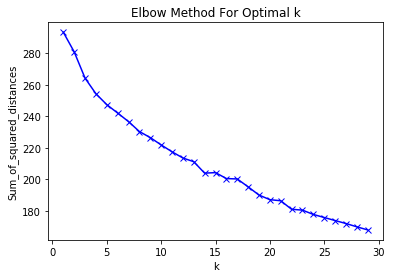

In [57]:
grouped_clustering = grouped.drop('Neighborhood', 1)
Sum_of_squared_distances = []
K = range(1, 30)
for kclusters in K:
    km = KMeans(n_clusters=kclusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001,  random_state=10).fit(grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Silhouette score method to determine the number of clusters

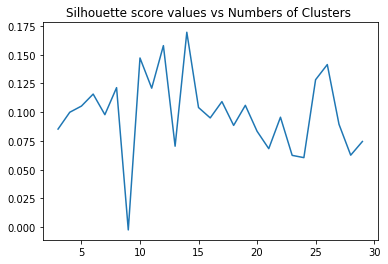

Optimal number of components is:
14


In [59]:
import numpy as numpy
import sklearn
import matplotlib.pyplot as plt
 
obs = grouped_clustering.copy() 
# obs = numpy.concatenate( (numpy.random.randn(100, 2) , 20 + numpy.random.randn(300, 2) , -15+numpy.random.randn(200, 2)))
silhouette_score_values=list()
 
NumberOfClusters=range(3,30)
 
for i in NumberOfClusters:
    
    classifier=KMeans(i,init='k-means++', n_init=10, max_iter=300, tol=0.0001, random_state=10)
    classifier.fit(obs)
    labels= classifier.predict(obs)
#     print("Number Of Clusters:")
#     print(i)
#     print("Silhouette score value")
#     print(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', sample_size=None, random_state=None))
    silhouette_score_values.append(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', random_state=0))
 
plt.plot(NumberOfClusters, silhouette_score_values)
plt.title("Silhouette score values vs Numbers of Clusters ")
plt.show()
 
Optimal_NumberOf_Components=NumberOfClusters[silhouette_score_values.index(max(silhouette_score_values))]
print("Optimal number of components is:")
print(Optimal_NumberOf_Components)

#### So from above two ways to determine the number of clusters, it is clear that 14 is optimum.

In [60]:
# set number of clusters
kclusters = 14

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([ 1,  5,  5, 11,  1, 11,  5,  1,  2, 10], dtype=int32)

In [69]:
#Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'ClusterLabels', kmeans.labels_)

merged = df_f

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
merged = merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

merged.head() # check the last columns!

Borough                                 Neighborhood Latitude  \
0        North York                                    Parkwoods  43.7533   
1        North York                             Victoria Village  43.7259   
2  Downtown Toronto                    Regent Park, Harbourfront  43.6543   
3        North York             Lawrence Manor, Lawrence Heights  43.7185   
4  Downtown Toronto  Queen's Park, Ontario Provincial Government  43.6623   

  Longitude  ClusterLabels  1st Most Common Venue 2nd Most Common Venue  \
0  -79.3297            7.0      Food & Drink Shop                  Park   
1  -79.3156           10.0  Portuguese Restaurant     French Restaurant   
2  -79.3606           10.0            Coffee Shop                Bakery   
3  -79.4648           11.0         Clothing Store    Miscellaneous Shop   
4  -79.3895           10.0            Coffee Shop                 Diner   

    3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue  \
0             Event Space        Farmers Market                   Farm   
1            Hockey Arena           Coffee Shop            Pizza Place   
2                    Park        Breakfast Spot                   Café   
3  Furniture / Home Store           Coffee Shop  Vietnamese Restaurant   
4             Music Venue                  Café     College Auditorium   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0     Falafel Restaurant               Factory            Eye Doctor   
1                Exhibit                  Farm    Falafel Restaurant   
2                    Pub            Restaurant               Theater   
3            Event Space              Boutique             Gift Shop   
4  General Entertainment    Mexican Restaurant   Arts & Crafts Store   

  9th Most Common Venue 10th Most Common Venue  
0               Exhibit            Zoo Exhibit  
1               Factory             Eye Doctor  
2                  Bank   Gym / Fitness Center  
3         Women's Store      Accessories Store  
4        Sandwich Place            Art Gallery

In [70]:
merged=merged.dropna()

In [71]:
merged['ClusterLabels'] = merged.ClusterLabels.astype(int)
merged.head()

Borough                                 Neighborhood Latitude  \
0        North York                                    Parkwoods  43.7533   
1        North York                             Victoria Village  43.7259   
2  Downtown Toronto                    Regent Park, Harbourfront  43.6543   
3        North York             Lawrence Manor, Lawrence Heights  43.7185   
4  Downtown Toronto  Queen's Park, Ontario Provincial Government  43.6623   

  Longitude  ClusterLabels  1st Most Common Venue 2nd Most Common Venue  \
0  -79.3297              7      Food & Drink Shop                  Park   
1  -79.3156             10  Portuguese Restaurant     French Restaurant   
2  -79.3606             10            Coffee Shop                Bakery   
3  -79.4648             11         Clothing Store    Miscellaneous Shop   
4  -79.3895             10            Coffee Shop                 Diner   

    3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue  \
0             Event Space        Farmers Market                   Farm   
1            Hockey Arena           Coffee Shop            Pizza Place   
2                    Park        Breakfast Spot                   Café   
3  Furniture / Home Store           Coffee Shop  Vietnamese Restaurant   
4             Music Venue                  Café     College Auditorium   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0     Falafel Restaurant               Factory            Eye Doctor   
1                Exhibit                  Farm    Falafel Restaurant   
2                    Pub            Restaurant               Theater   
3            Event Space              Boutique             Gift Shop   
4  General Entertainment    Mexican Restaurant   Arts & Crafts Store   

  9th Most Common Venue 10th Most Common Venue  
0               Exhibit            Zoo Exhibit  
1               Factory             Eye Doctor  
2                  Bank   Gym / Fitness Center  
3         Women's Store      Accessories Store  
4        Sandwich Place            Art Gallery

In [72]:
# create map
map_clusters = folium.Map()

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### So now let us see each cluster indivisually

In [74]:
#indivisual cluster distribution
merged.ClusterLabels.value_counts()

11    726
5     125
1     123
10     76
0      50
3      32
2      28
4      24
7      19
6       9
8       8
9       6
12      4
13      3
Name: ClusterLabels, dtype: int64

In [75]:
#Cluster 1
merged.loc[merged['ClusterLabels'] == 0, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
148                                            Edenwald           Supermarket   
337         Kumbalagodu,Kumbalgodu Gollahalli,Ramohalli           Bus Station   
450                                        Peerzadiguda    Chinese Restaurant   
549                                       Borivali East                  Park   
550   Daulat Nagar Mumbai,Magthane,Rajendra Nagar Mu...                  Park   
615          Masulkar Colony,Nehrunagar Pune,Pimpri P F   Fried Chicken Joint   
697   Belawadi,Bhavaninagar Pune,Bori,Kazad,Kuravali...           Bus Station   
698                             Dhekalwadi,Katyachiwadi           Bus Station   
718   Chilewadi,Dholwad,Dingore,Hivare KH,Khubi,Madh...           Bus Station   
733                                            Gulunche           Bus Station   
734                    Khandobachi Wadi,Nimbut,Nira R S           Bus Station   
799   Mangolpuri A Block,Mangolpuri I Block,Mangolpu...                   ATM   
1124                                              Youyi    Chinese Restaurant   
1133                                              Yuepu    Chinese Restaurant   
1139                                            Qingcun    Chinese Restaurant   
1150                                        Linfen Road          Dessert Shop   
1155                                             Shihua                 Hotel   
1160                                           Shanyang    Chinese Restaurant   
1170                                            Meilong        Farmers Market   
1178                                            Hudong     Chinese Restaurant   
1181                                           Nanmatou    Chinese Restaurant   
1199                                            Laogang    Chinese Restaurant   
1205                                           Xinchang    Chinese Restaurant   
1212                         Waigaoqiao Free-Trade zone      Business Service   
1214                                       Xianghuaqiao    Chinese Restaurant   
1227                                          Jiuliting    Chinese Restaurant   
1230                                          Zhongshan  Cantonese Restaurant   
1231                                             Chedun   Dumpling Restaurant   
1233                                            Jiuting  Fast Food Restaurant   
1237                                             Sijing    Chinese Restaurant   
1241                                              Yexie    Chinese Restaurant   
1244                                          Caohejing         Metro Station   
1258                                           Changbai    Chinese Restaurant   
1261                                          Kongjiang    Chinese Restaurant   
1267                                            Yinhang    Chinese Restaurant   
1290                                         Balizhuang    Chinese Restaurant   
1301                                        Xiaohongmen                  Café   
1304                                       Laiguangying    Chinese Restaurant   
1307                                         Guanzhuang         Metro Station   
1342                                            Longtan    Chinese Restaurant   
1345                                     Yongdingmenwai    Chinese Restaurant   
1356                                          Zhangfang    Chinese Restaurant   
1361                                            Fengtai    Chinese Restaurant   
1375                                       Wanshou Road    Chinese Restaurant   
1379                                         Balizhuang    Chinese Restaurant   
1382                                       Xueyuan Road              Bus Stop   
1404                                             Qiaozi    Chinese Restaurant   
1407                                              Bohai    Chinese Restaurant   
1412                                          Xinjiekou    Chinese Restaur

In [76]:
#Cluster 2
merged.loc[merged['ClusterLabels'] == 1, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
25                                             Christie         Grocery Store   
39                                      Bayview Village    Chinese Restaurant   
43         Brockton, Parkdale Village, Exhibition Place                  Café   
58                          Birch Cliff, Cliffside West                  Café   
74                  The Annex, North Midtown, Yorkville        Sandwich Place   
80                       University of Toronto, Harbord                  Café   
229                                       Richmond Town            Bagel Shop   
251                                     Lighthouse Hill                  Café   
259                                               Agram                  Café   
260                                  Air Force Hospital                  Café   
261   Amruthahalli,Byatarayanapura,Kodigehalli,Sahak...       Badminton Court   
270                                  Bellandur,Panathur              Pharmacy   
271                                         Benson Town           Music Venue   
275       CMP Centre & School,Museum Road,Richmond Town                  Café   
282   Doorvaninagar,Krishnarajapuram R S,Ramamurthy ...                  Café   
290                                         H.K.P. Road                  Café   
294                      J.C.Nagar,Training Command IAF            Playground   
296                      Lingarajapuram,St. Thomas Town     Convenience Store   
301                                Sivan Chetty Gardens     Indian Restaurant   
302                                             Adugodi                  Café   
304   Ashoknagar Bangalore,Banashankari,DasarahalliS...  Fast Food Restaurant   
335                      Jayanagar,Tilaknagar Bangalore     Indian Restaurant   
349                           Gayathrinagar,Srirampuram                  Café   
356      Laggere,Peenya I Stage,Peenya Small Industries    Light Rail Station   
361                    Mathikere,Msrit,Sri Chowdeshwari        Clothing Store   
376                                         Bettahalsur                  Café   
377   Chikkajala,Doddajala,Hunasamaranahalli,Tarahun...                  Café   
385   A.Gs Office,Anandnagar Hyderabad,Bazarghat Hyd...                  Café   
386                                    Parishram Bhawan                  Café   
387                              Vidhan Sabha Hyderabad                  Café   
...                                                 ...                   ...   
834   D.E.S.U. Colony,Jail Road West Delhi,Janakpuri...                  Café   
837   Jawala Heri,Madipur Slum Quarter,Madipur Villa...                  Café   
899                                      Porte-Dauphine                  Café   
969   Brent Park,Church End,Harlesden,Kensal Green,S...                  Café   
970                                      Old Oak Common                  Café   
971                                          Park Royal                  Café   
983     Camden Town,Chalk Farm,Primrose Hill,Somerstown                Garden   
1002                                         Gipsy Hill                  Café   
1003                                      Upper Norwood                  Café   
1006                                      Sydenham Hill                  Café   
1010                                            Dulwich               Brewery   
1011                                      Sydenham Hill                  Café   
1040                            Gospel Oak,Kentish Town                   Pub   
1057                              Hither Green,Lewisham                   Pub   
1070                                           Ladywell                   Pub   
1075                        Lisson Grove,St John's Wood                  Café   
1081                                            Neasden                  Café   
1082                                          New Cross                  C

In [77]:
#Cluster 3
merged.loc[merged['ClusterLabels'] == 2, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
278                        Devasandra,Krishnarajapuram                   ATM   
352                                     Jalahalli East                   ATM   
389                               AP Police Academy PO                   ATM   
390                                      Hydershahkote                   ATM   
406                                 Ibrahim Bagh Lines                   ATM   
412                               Raj Bhawan Hyderabad                   ATM   
421                                        Bahadurpura                   ATM   
422                     Hussainialam,Kishanbagh,Tadbun                   ATM   
431                                    Don Bosco Nagar                   ATM   
438                               Hindustan Cables Ltd                   ATM   
454                                        Saroornagar                   ATM   
464                                        Allampalli.                   ATM   
469  Ankireddipalli,Ankushapur,Bogaram,Cherial,Cher...                   ATM   
475                                 Balanagar Township                   ATM   
476                       CIE Balangar,Rangareddynagar                   ATM   
485   Dr As Rao Nagar,Ecil,Jai Jawan Colony,Kushaiguda                   ATM   
495    Katchavanisingaram,Rajeevagruhakalpa,Samskruthi                   ATM   
496                            Korremal,Pratapsingaram                   ATM   
505                               Nehrunagar Hyderabad                   ATM   
511                                          Vikarabad                   ATM   
612                                          Kasarwadi                   ATM   
626                                    Anandnagar Pune                   ATM   
641  Dhayari,Nanded,Sinhgad Technical Education Soc...                   ATM   
642                                     Vadgaon Budruk                   ATM   
646          Kasba Peth,Mangalwar Peth Pune,Rasta Peth                   ATM   
762                      Phursungi,Uruli Devachi,Vadki                   ATM   
808  Badarpur South Delhi,BTPS South Delhi,Jaitpur,...                   ATM   
833  D. K. Mohan Garden,Hastal Village,Jeevan Park,...                   ATM   

     2nd Most Common Venue 3rd Most Common Venue        4th Most Common Venue  \
278      Andhra Restaurant                Market                   Eye Doctor   
352    Filipino Restaurant     Electronics Store          Empanada Restaurant   
389            Music Venue              Creperie  Eastern European Restaurant   
390            Music Venue              Creperie  Eastern European Restaurant   
406    Filipino Restaurant     Electronics Store          Empanada Restaurant   
412            Music Venue              Creperie  Eastern European Restaurant   
421    Filipino Restaurant     Electronics Store          Empanada Restaurant   
422    Filipino Restaurant     Electronics Store          Empanada Restaurant   
431    Filipino Restaurant     Electronics Store          Empanada Restaurant   
438            Music Venue              Creperie  Eastern European Restaurant   
454       Business Service            Eye Doctor         Fast Food Restaurant   
464            Music Venue              Creperie  Eastern European Restaurant   
469            Outlet Mall                 Field            Electronics Store   
475    Filipino Restaurant     Electronics Store          Empanada Restaurant   
476    Filipino Restaurant     Electronics Store          Empanada Restaurant   
485    Filipino Restaurant     Electronics Store          Empanada Restaurant   
495            Outlet Mall                 Field            Electronics Store   
496            Outlet Mall                 Field            Electronics Store   
505         Ice Cream Shop               Exhibit         Fast Food Restaurant   
511            Music Venue              Creperie  Eastern European Restaurant   
612    Filipino Rest

In [78]:
#Cluster 4
merged.loc[merged['ClusterLabels'] == 3, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
306   Banashankari III Stage,Girinagar Bangalore,Kat...       Motorcycle Shop   
433                           Fatehdarwaza,Shahalibanda               Theater   
597                                               C M E         Historic Site   
598                                            Chikhali         Historic Site   
599                                  Rupeenagar,Talwade         Historic Site   
608                             Infotech Park Hinjawadi         Historic Site   
609                                             Marunji         Historic Site   
610                                               Wakad         Historic Site   
621                                                Srpf         Historic Site   
629                                               Aundh         Historic Site   
630                              Aundh T.S.,Ganeshkhind         Historic Site   
659      Ala Pune,Alephata,Bori BK,Rajuri,Vadgaon Anand         Historic Site   
669   Ambade,Ambavade,Ambeghar,Apti,Bari BK,Bazarwad...         Historic Site   
685   Arvi Pune,Gunjalwadi,Pimpalgaon Tarfa Narayang...         Historic Site   
686   Ashtapur,Dahitane,Kesnand,Koregaon Bhivar,Vade...         Historic Site   
687                                 Rahu,Telewadi,Walki         Historic Site   
691                                Avsari KH,Gawadewadi         Historic Site   
701   Bhamburde,Ganegaon Khalasa,Karanjawane,Kondhap...         Historic Site   
711                  Bibi,Chas Pune,Kadadhe,Tiwai Hills         Historic Site   
715   Burunjwadi,Dhanore,Hivare,Jategaon BK,Karandi,...         Historic Site   
722        Daundaj,Harni,Jeur,Mandki,Pingori,Rakh,Valha         Historic Site   
723   Dawanewadi,Hargude,Kaldari,Mahur,Mandhar,Parinche         Historic Site   
730                                 Gangapur KH,Shinoli         Historic Site   
743                                        Kaivalyadham         Historic Site   
745   Kandali,Kolvadi,Pimpalwandi Pune,Umbraj,Vadgao...         Historic Site   
747      Karegaon,Midc Ranjangaon Ganpati,Nimgaon Bhogi         Historic Site   
748               Karegaon,Pargaon Tarfe Khed,Peth Pune       Motorcycle Shop   
749                                    Kurwandi,Thugaon       Motorcycle Shop   
752                               Kolwadi,Naygaon,Theur         Historic Site   
763                                         Tondal,Veer         Historic Site   
1131                                            Songnan             Multiplex   
1331                                           Jingshan         Historic Site   

     2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
306         Ice Cream Shop               Exhibit  Fast Food Restaurant   
433            Zoo Exhibit               Exhibit        Farmers Market   
597              Multiplex       Motorcycle Shop               Theater   
598              Multiplex       Motorcycle Shop               Theater   
599              Multiplex       Motorcycle Shop               Theater   
608              Multiplex       Motorcycle Shop               Theater   
609              Multiplex       Motorcycle Shop               Theater   
610              Multiplex       Motorcycle Shop               Theater   
621              Multiplex       Motorcycle Shop               Theater   
629              Multiplex       Motorcycle Shop               Theater   
630              Multiplex       Motorcycle Shop               Theater   
659              Multiplex       Motorcycle Shop               Theater   
669              Multiplex       Motorcycle Shop               Theater   
685              Multiplex       Motorcycle Shop               Theater   
686              Multiplex       Motorcycle Shop               Theater   
687              Multiplex       Motorcycle Shop               Theater   
691              Multiplex       Motorcycle Shop               Theater   
701              Multiplex       Moto

In [79]:
#Cluster 5
merged.loc[merged['ClusterLabels'] == 4, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
6                                        Malvern, Rouge  Fast Food Restaurant   
320                                Chamrajpet Bangalore  Fast Food Restaurant   
334   J P Nagar,JP Nagar III Phase,Kumaraswamy Layou...       Motorcycle Shop   
338                                        Nayandahalli  Fast Food Restaurant   
354                                      Jalahalli West             BBQ Joint   
548   Bangur Nagar,Goregaon RS,Goregaon Mumbai,Motil...  Fast Food Restaurant   
560                                     Jogeshwari East  Fast Food Restaurant   
822              Bagdola,Barthal,Dhulsiras,Raj Nagar II  Fast Food Restaurant   
827                             Kakrola,N.S.I.T. Dwarka  Fast Food Restaurant   
1017                                       East Dulwich  Fast Food Restaurant   
1125                                          Zhangmiao  Fast Food Restaurant   
1174                                          Zhuanqiao         Metro Station   
1201                                             Sanlin  Fast Food Restaurant   
1215                                            Xiayang  Fast Food Restaurant   
1232                                           Dongjing         Metro Station   
1266                                              Yanji  Fast Food Restaurant   
1318                                       Tiangongyuan         Metro Station   
1323                                            Yinghai         Metro Station   
1347                                          Xingcheng         Metro Station   
1352                                             Yancun  Fast Food Restaurant   
1365                                          Dahongmen         Metro Station   
1392                                            Shangdi         Metro Station   
1399                                            Huairou  Fast Food Restaurant   
1421                                              Gulou  Fast Food Restaurant   

     2nd Most Common Venue  3rd Most Common Venue 4th Most Common Venue  \
6               Print Shop            Event Space        Farmers Market   
320      Indian Restaurant  General Entertainment            Print Shop   
334          Metro Station    Empanada Restaurant    English Restaurant   
338      Accessories Store                   Road               Exhibit   
354   Fast Food Restaurant                Exhibit        Farmers Market   
548            Flea Market          Movie Theater           Zoo Exhibit   
560            Zoo Exhibit    Filipino Restaurant     Electronics Store   
822               Pharmacy            Event Space        Farmers Market   
827    Fried Chicken Joint    Filipino Restaurant     Electronics Store   
1017                   Pub            Event Space        Farmers Market   
1125         Metro Station            Coffee Shop     Convenience Store   
1174  Fast Food Restaurant            Zoo Exhibit            Eye Doctor   
1201           Zoo Exhibit    Filipino Restaurant     Electronics Store   
1215                 Hotel             Restaurant           Zoo Exhibit   
1232           Zoo Exhibit             Eye Doctor  Fast Food Restaurant   
1266         Metro Station              Rock Club                 Hotel   
1318        Adult Boutique   Fast Food Restaurant           Zoo Exhibit   
1323           Zoo Exhibit             Eye Doctor  Fast Food Restaurant   
1347           Zoo Exhibit             Eye Doctor  Fast Food Restaurant   
1352           Zoo Exhibit    Filipino Restaurant     Electronics Store   
1365           Zoo Exhibit             Eye Doctor  Fast Food Restaurant   
1392            Playground   Fast Food Restaurant             Bookstore   
1399   Dumpling Restaurant          Shopping Mall           Coffee Shop   
1421            Theme Park                 Buffet               Exhibit   

     5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
6                     Farm    Falafel Restaurant               Fact

In [80]:
#Cluster 6
merged.loc[merged['ClusterLabels'] == 5, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
65   Dorset Park, Wexford Heights, Scarborough Town...     Indian Restaurant   
258         A F Station Yelahanka,BSF Campus Yelahanka     Indian Restaurant   
262    Anandnagar Bangalore,H.A. Farm,Hebbal Kempapura           Bus Station   
264  Attur,CRPF Campus Yelahanka,Jakkur,Rajanakunte...    Athletics & Sports   
267      Banaswadi,Horamavu,Jalavayuvihar,Kalyananagar     Indian Restaurant   
268  Bangalore Bazaar,Dr. Ambedkar Veedhi,HighCourt...     Indian Restaurant   
269                                  CMM Court Complex     Indian Restaurant   
274                                    C.V.Raman Nagar     Indian Restaurant   
281                                             Domlur     Indian Restaurant   
283                                               EPIP     Indian Restaurant   
284                                         Whitefield     Indian Restaurant   
287                                             Gunjur   Indie Movie Theater   
288                                 Muthusandra,Vartur   Indie Movie Theater   
289                       H.A.L II Stage,Hulsur Bazaar     Indian Restaurant   
291                                 Hoodi,Mahadevapura     Indian Restaurant   
292                              Indiranagar Bangalore    Chinese Restaurant   
293  ISRO Anthariksha Bhavan,R.M.V. Extension II Stage     Indian Restaurant   
297                                  Maruthi Sevanagar     Kerala Restaurant   
298                                     NAL,Vimanapura  Fast Food Restaurant   
300                                     Sadashivanagar     Indian Restaurant   
303  Agara,Koramangala I Block,Koramangala,St. John...     Indian Restaurant   
305  B Sk II Stage,Jayanagar West,Padmanabhnagar,Ty...     Indian Restaurant   
307                     Bangalore Corporation Building     Indian Restaurant   
308                                     Bangalore City     Indian Restaurant   
309  Bannerghatta Road,Hulimavu,JP Nagar VIII phase...                Bakery   
310                                           Hulimavu                Bakery   
311                             Bannerghatta,Gottigere     Indian Restaurant   
312                                          Ragihalli     Indian Restaurant   
313            Basavanagudi,Mavalli,Pampamahakavi Road     Indian Restaurant   
314                                     Thyagarajnagar     Indian Restaurant   
..                                                 ...                   ...   
614                                           Lohogaon      Business Service   
619                                       Pimple Gurav           Snack Place   
622                               Yerwada,Yerwada T.S.           Pizza Place   
623          A.R. Shala,Deccan Gymkhana,Film Institute     Indian Restaurant   
636       Bhusari Colony,Ex. Serviceman Colony,Kothrud     Indian Restaurant   
640                                         Dhankawadi     Indian Restaurant   
645                             Karvenagar,Navsahyadri                  Café   
647                                   Khadakwasla R.S.     Indian Restaurant   
650  Lokmanyanagar,Narayan Peth,Rashtra Bhasha Bhav...     Indian Restaurant   
660  Alande,Anantnagar Nigade,Bhongavali,Dhangavadi...        Breakfast Spot   
661  ArviHaveli,GogalwadiE,Kalyan,Khed Shivapur,Khe...        Breakfast Spot   
662                                          Ketkavale        Breakfast Spot   
663  Alandi Chorachi,Kadam Wak Wasti,Kunjirwadi,Lon...     Indian Restaurant   
672  Ambarvet,Andgaon,Bhugaon,Bhukum,Ghotavade,Kham...     Indian Restaurant   
673                                            Sangrun     Indian Restaurant   
740                                   Kadethan,Varvand     Mobile Phone Shop   
766  Anand Parbat Indl. Area,Anand Parbat,Bank Stre...  Fast Food Restaurant   
771  Hauz Qazi,Jama Masjid,Delhi G.P.O.,Chandni Cho...     Indian Restaurant   
776                    Union Public Servic

In [81]:
#Cluster 7
merged.loc[merged['ClusterLabels'] == 6, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
1132      Yanghang                 Hotel         Big Box Store   
1136        Haiwan                 Hotel           Zoo Exhibit   
1189         Caolu               Brewery                 Hotel   
1195        Heqing                 Hotel           Zoo Exhibit   
1200       Nicheng                 Hotel           Zoo Exhibit   
1206      Xuanqiao                 Hotel           Zoo Exhibit   
1269     Changxing                 Hotel           Zoo Exhibit   
1276  Qianwei Farm                 Hotel           Zoo Exhibit   
1385   Qinghuayuan                 Hotel         Metro Station   

     3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
1132           Coffee Shop           Zoo Exhibit   Filipino Restaurant   
1136            Eye Doctor  Fast Food Restaurant        Farmers Market   
1189           Zoo Exhibit            Eye Doctor  Fast Food Restaurant   
1195            Eye Doctor  Fast Food Restaurant        Farmers Market   
1200            Eye Doctor  Fast Food Restaurant        Farmers Market   
1206            Eye Doctor  Fast Food Restaurant        Farmers Market   
1269            Eye Doctor  Fast Food Restaurant        Farmers Market   
1276            Eye Doctor  Fast Food Restaurant        Farmers Market   
1385           Coffee Shop           Zoo Exhibit                 Field   

     6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
1132  Fast Food Restaurant        Farmers Market                  Farm   
1136                  Farm    Falafel Restaurant               Factory   
1189        Farmers Market                  Farm    Falafel Restaurant   
1195                  Farm    Falafel Restaurant               Factory   
1200                  Farm    Falafel Restaurant               Factory   
1206                  Farm    Falafel Restaurant               Factory   
1269                  Farm    Falafel Restaurant               Factory   
1276                  Farm    Falafel Restaurant               Factory   
1385        Farmers Market                  Farm    Falafel Restaurant   

     9th Most Common Venue 10th Most Common Venue  
1132    Falafel Restaurant                Factory  
1136               Exhibit    Filipino Restaurant  
1189               Factory                Exhibit  
1195               Exhibit    Filipino Restaurant  
1200               Exhibit    Filipino Restaurant  
1206               Exhibit    Filipino Restaurant  
1269               Exhibit    Filipino Restaurant  
1276               Exhibit    Filipino Restaurant  
1385               Factory             Eye Doctor

In [82]:
#Cluster 8
merged.loc[merged['ClusterLabels'] == 7, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
0                                             Parkwoods     Food & Drink Shop   
21                                  Caledonia-Fairbanks                  Park   
35        East Toronto, Broadview North (Old East York)                  Park   
61                                        Lawrence Park                  Park   
66                                      York Mills West                  Park   
85    Milliken, Agincourt North, Steeles East, L'Amo...            Playground   
91                                             Rosedale                  Park   
130                                        Clason Point                  Park   
184                                           Todt Hill                 Trail   
342                                     Ullalu Upanagar                  Park   
353                                           Jalahalli                  Park   
363                                       Nandinilayout                  Park   
472              Aphb Colony Moulali,Ie Moulali,Moulali                  Park   
634                              Baner Road,N.C.L. Pune                  Park   
777                                         Garhi Mandu                  Park   
1243                          Songjiang Industrial Zone     Indian Restaurant   
1303                                           Pingfang                  Park   
1380                                          Zizhuyuan     Korean Restaurant   
1384                                            Haidian                  Park   

     2nd Most Common Venue       3rd Most Common Venue 4th Most Common Venue  \
0                     Park                 Event Space        Farmers Market   
21           Women's Store                        Pool           Zoo Exhibit   
35       Convenience Store                 Zoo Exhibit               Exhibit   
61                Bus Line                 Swim School           Zoo Exhibit   
66       Convenience Store  Construction & Landscaping           Zoo Exhibit   
85                    Park                     Exhibit  Fast Food Restaurant   
91                   Trail                  Playground           Zoo Exhibit   
130      Convenience Store                    Bus Stop                  Pool   
184                   Park                 Zoo Exhibit               Exhibit   
342            Zoo Exhibit                       Field     Electronics Store   
353          Grocery Store                 Zoo Exhibit               Exhibit   
363                 Bakery                    Bus Line            Food Truck   
472            Coffee Shop                 Zoo Exhibit               Exhibit   
634            Zoo Exhibit                       Field     Electronics Store   
777            Zoo Exhibit                       Field     Electronics Store   
1243                  Park                 Zoo Exhibit               Exhibit   
1303   Szechuan Restaurant                       Hotel           Zoo Exhibit   
1380                  Park                        Pier           Zoo Exhibit   
1384           Zoo Exhibit                       Field     Electronics Store   

          5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                          Farm    Falafel Restaurant               Factory   
21                  Event Space                  Farm    Falafel Restaurant   
35               Farmers Market                  Farm    Falafel Restaurant   
61                   Eye Doctor  Fast Food Restaurant        Farmers Market   
66                      Exhibit        Farmers Market                  Farm   
85               Farmers Market                  Farm    Falafel Restaurant   
91                  Event Space                  Farm    Falafel Restaurant   
130   South American Restaurant         Grocery Store         Boat or Ferry   
184              Farmers Market                  Farm    Falafel Restaurant   
342         Empanada Restaurant

In [83]:
#Cluster 9
merged.loc[merged['ClusterLabels'] == 8, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
483                                         Chandanagar         Train Station   
670             Ambale,Ambi,Induri,Umbre Navlakh,Varale         Train Station   
671                             Talegaon G H,Vishnupuri         Train Station   
784   C.C.I.,Delhi University,Gulabi Bagh,Kamla Naga...              Beer Bar   
802                 New Multan Nagar,Shakur Basti Depot         Train Station   
1211                                    Luchaogang Farm         Train Station   
1320                                           Huangcun         Train Station   
1326                                             Anding         Train Station   

     2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
483                    ATM           Event Space        Farmers Market   
670      Indian Restaurant           Bus Station           Zoo Exhibit   
671      Indian Restaurant           Bus Station           Zoo Exhibit   
784          Train Station           Zoo Exhibit               Exhibit   
802            Zoo Exhibit           Event Space        Farmers Market   
1211           Zoo Exhibit           Event Space        Farmers Market   
1320         Metro Station           Zoo Exhibit            Eye Doctor   
1326           Zoo Exhibit           Event Space        Farmers Market   

     5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
483                   Farm    Falafel Restaurant               Factory   
670                Exhibit        Farmers Market                  Farm   
671                Exhibit        Farmers Market                  Farm   
784         Farmers Market                  Farm    Falafel Restaurant   
802                   Farm    Falafel Restaurant               Factory   
1211                  Farm    Falafel Restaurant               Factory   
1320  Fast Food Restaurant        Farmers Market                  Farm   
1326                  Farm    Falafel Restaurant               Factory   

     8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
483             Eye Doctor               Exhibit          Event Service  
670     Falafel Restaurant               Factory             Eye Doctor  
671     Falafel Restaurant               Factory             Eye Doctor  
784                Factory            Eye Doctor            Event Space  
802             Eye Doctor               Exhibit          Event Service  
1211            Eye Doctor               Exhibit          Event Service  
1320    Falafel Restaurant               Factory            Event Space  
1326            Eye Doctor               Exhibit          Event Service

In [84]:
#Cluster 10
merged.loc[merged['ClusterLabels'] == 9, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
319                                          Carmelram     Mobile Phone Shop   
658             Agoti,Dalaj,Loni Deokar,Nhavi,Palasdeo     Mobile Phone Shop   
681  Amondi,Ghodegaon Pune,Girawali,Pimpalgaon Tarf...     Mobile Phone Shop   
689  Avasari BK,Lakhangaon,Nirgudsar,Pargaon Tarfe ...     Mobile Phone Shop   
695  Bawada,Bhandgaon,Bhodani,Lakhewadi,Pimpri BK,S...     Mobile Phone Shop   
699  Belsar,Javalarjun,Jejuri,Kolvihire,Kothale,Mav...     Mobile Phone Shop   

    2nd Most Common Venue 3rd Most Common Venue       4th Most Common Venue  \
319          Dessert Shop           Zoo Exhibit  Financial or Legal Service   
658           Zoo Exhibit            Eye Doctor        Fast Food Restaurant   
681           Zoo Exhibit            Eye Doctor        Fast Food Restaurant   
689           Zoo Exhibit            Eye Doctor        Fast Food Restaurant   
695           Zoo Exhibit            Eye Doctor        Fast Food Restaurant   
699           Zoo Exhibit            Eye Doctor        Fast Food Restaurant   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
319                 Field  Fast Food Restaurant        Farmers Market   
658        Farmers Market                  Farm    Falafel Restaurant   
681        Farmers Market                  Farm    Falafel Restaurant   
689        Farmers Market                  Farm    Falafel Restaurant   
695        Farmers Market                  Farm    Falafel Restaurant   
699        Farmers Market                  Farm    Falafel Restaurant   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
319                  Farm    Falafel Restaurant                Factory  
658               Factory               Exhibit    Filipino Restaurant  
681               Factory               Exhibit    Filipino Restaurant  
689               Factory               Exhibit    Filipino Restaurant  
695               Factory               Exhibit    Filipino Restaurant  
699               Factory               Exhibit    Filipino Restaurant

In [85]:
#Cluster 11
merged.loc[merged['ClusterLabels'] == 10, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Neighborhood  \
1                                      Victoria Village   
2                             Regent Park, Harbourfront   
4           Queen's Park, Ontario Provincial Government   
22                                               Woburn   
24                                   Central Bay Street   
34                      Northwood Park, York University   
38          Kennedy Park, Ionview, East Birchmount Park   
56     Del Ray, Mount Dennis, Keelsdale and Silverthorn   
70                                            Westmount   
72                          Willowdale, Willowdale West   
76                Canada Post Gateway Processing Centre   
90                        Steeles West, L'Amoreaux West   
200                                         Silver Lake   
219                                       Arden Heights   
221                                   Heartland Village   
350                                          Hampinagar   
400   Gagan Mahal,Himayathnagar,Narayanguda,Ramakris...   
423                            Barkatpura,Stn Kachiguda   
424                                         Nimboliadda   
439                        Hyderabad Jubilee,Moghalpura   
518                Kidwai Nagar Mumbai,Wadala Rs,Wadala   
526               Andheri Railway Station,H.M.P. School   
582   Kapad Bazar,Mahim Bazar,Mahim East,Mahim,Mori ...   
583                                        Malabar Hill   
603                                 Dapodi Bazar,Dapodi   
617                                  Mundhva AV,Mundhva   
780                                         Aruna Nagar   
781   Civil Lines North Delhi,District Courts North ...   
814   Malviya Nagar South Delhi,MMTC/STC Colony,Panc...   
919                                          Abbey Wood   
...                                                 ...   
1250                                       Lingyun Road   
1251                                            Longhua   
1252                                            Tianlin   
1253                                      Tianping Road   
1254                                         Xietu Road   
1255                                          Xujiahui    
1256                                            Huajing   
1257                             Caohejing Hi-Tech Park   
1259                                       Dinghai Road   
1277                                            Jianwai   
1278                                            Chaowai   
1281                                       Zuojiazhuang   
1283                                             Anzhen   
1284                                           Yayuncun   
1289                                           Liulitun   
1292                                            Jinsong   
1295                                              Datun   
1300                                        Taiyanggong   
1321                                            Jiugong   
1336                                        Chaoyangmen   
1338                                         Dongzhimen   
1340                                            Qianmen   
1341                                         Donghuashi   
1371                                         Fangzhuang   
1377                                       Yangfangdian   
1378                                          Ganjiakou   
1383                                       Zhongguancun   
1387                                             Qinghe   
1398                                           Longshan   
1410                                            Jinrong   

              1st Most Common Venue      2nd Most Common Venue  \
1             Portuguese Restaurant          French Restaurant   
2                       Coffee Shop                     Bakery   
4                       Coffee Shop                      Diner   
22                      Coffee Shop          Korean Restaurant   
24                      Coffee Shop         Italian Re

In [86]:
#Cluster 12
merged.loc[merged['ClusterLabels'] == 11, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
3                      Lawrence Manor, Lawrence Heights        Clothing Store   
7                                             Don Mills                   Gym   
8                       Parkview Hill, Woodbine Gardens           Pizza Place   
9                              Garden District, Ryerson           Coffee Shop   
10                                            Glencairn           Pizza Place   
12               Rouge Hill, Port Union, Highland Creek                   Bar   
13                                            Don Mills                   Gym   
14                                     Woodbine Heights                  Park   
15                                       St. James Town                  Café   
16                                   Humewood-Cedarvale                 Field   
17    Eringate, Bloordale Gardens, Old Burnhamthorpe...            Beer Store   
18                    Guildwood, Morningside, West Hill          Intersection   
19                                          The Beaches                   Pub   
20                                          Berczy Park           Coffee Shop   
23                                              Leaside           Coffee Shop   
26                                            Cedarbrae   Fried Chicken Joint   
27                                    Hillcrest Village           Golf Course   
28      Bathurst Manor, Wilson Heights, Downsview North           Coffee Shop   
29                                     Thorncliffe Park     Indian Restaurant   
30                             Richmond, Adelaide, King           Coffee Shop   
31                         Dufferin, Dovercourt Village                Bakery   
32                                  Scarborough Village            Playground   
33                         Fairview, Henry Farm, Oriole        Clothing Store   
36    Harbourfront East, Union Station, Toronto Islands           Coffee Shop   
37                             Little Portugal, Trinity                   Bar   
40                                            Downsview         Grocery Store   
41                         The Danforth West, Riverdale      Greek Restaurant   
42             Toronto Dominion Centre, Design Exchange           Coffee Shop   
44                      Golden Mile, Clairlea, Oakridge              Bus Line   
46                                            Downsview         Grocery Store   
...                                                 ...                   ...   
1350                                        Zhoukoudian        History Museum   
1353                                            Doudian   Dumpling Restaurant   
1354                                          Changyang         Metro Station   
1362                                           Youanmen    Beijing Restaurant   
1363                                        Taipingqiao                 Hotel   
1364                                          Xiluoyuan     Electronics Store   
1367                                          Lugouqiao            Toll Plaza   
1368                                            Majiapu           Supermarket   
1370                                            Wangzuo                   Bar   
1372                                       Wanpingcheng           Pizza Place   
1376                                      Yongding Road                  Park   
1381                                   Beitaipingzhuang     Hotpot Restaurant   
1386                                          Xiangshan  Fast Food Restaurant   
1388                                       Huayuan Road      Henan Restaurant   
1389                                            Xisanqi    Chinese Restaurant   
1390                                           Malianwa         Metro Station   
1393                                             Wanliu           Karaoke Bar   
1395                                            Wenquan          Food Serv

In [87]:
#Cluster 13
merged.loc[merged['ClusterLabels'] == 12, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
383           Dasanapura,Madanayakanahalli                  Café   
465  Alwal,Bolarum Bazar,Bolarum,Haiglines                  Café   
466                                Kowkoor                  Café   
620                                Sangavi                  Café   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
383           Zoo Exhibit            Eye Doctor  Fast Food Restaurant   
465           Zoo Exhibit            Eye Doctor  Fast Food Restaurant   
466           Zoo Exhibit            Eye Doctor  Fast Food Restaurant   
620           Zoo Exhibit            Eye Doctor  Fast Food Restaurant   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
383        Farmers Market                  Farm    Falafel Restaurant   
465        Farmers Market                  Farm    Falafel Restaurant   
466        Farmers Market                  Farm    Falafel Restaurant   
620        Farmers Market                  Farm    Falafel Restaurant   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
383               Factory               Exhibit           Costume Shop  
465               Factory               Exhibit           Costume Shop  
466               Factory               Exhibit           Costume Shop  
620               Factory               Exhibit           Costume Shop

In [88]:
#Cluster 14
merged.loc[merged['ClusterLabels'] == 13, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
786  Adrash Nagar,Bhalaswa,Jahangir Puri A Block,Ja...     Electronics Store   
792  Bankner,Bhorgarh,Kanya Gurukul,Lampur,Narela,S...     Electronics Store   
796  Ganeshpura,Keshav Puram North West Delhi,Onkar...     Electronics Store   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
786           Zoo Exhibit   Filipino Restaurant   Empanada Restaurant   
792           Zoo Exhibit   Filipino Restaurant   Empanada Restaurant   
796           Zoo Exhibit   Filipino Restaurant   Empanada Restaurant   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
786    English Restaurant  Ethiopian Restaurant         Event Service   
792    English Restaurant  Ethiopian Restaurant         Event Service   
796    English Restaurant  Ethiopian Restaurant         Event Service   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
786           Event Space               Exhibit             Eye Doctor  
792           Event Space               Exhibit             Eye Doctor  
796           Event Space               Exhibit             Eye Doctor

___

##### By observation of each cluster carefully, we can see that 
        - cluster 3,6,10,13 n 14 are local clusters of Indian cities
        - cluster 7 is a local cluster of Chinese cities
        - cluster 4 is full of Historic Site, Multiplex, Theater, Restaurant n other food shops so basically looks like a tourist place
        - rest all clusters are universal
        
##### So if someone wants to move locally within country then they can get help from the local clusters 3,6,10,13,14 n 7.
##### And for moving across countries one can find guidance from the other universal clusters.

### Thankyou
## The End